<a href="https://colab.research.google.com/github/anuda/EVA8/blob/main/S4/Assignment4_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target
- Intent is to get a basic model working end to end
- Set the model structure
- Implement data loader and transformation
- Since we are going to work on MNIST data we will try to build a lighter model
- Used **SGD optimizer** with **learning rate of 0.01 and momentum of 0.9**

- 
## Analysis
- Model doesnt seem to overfit
- It is a lighter model with **27.4K** parameters
- It is quite evident from the data that we need augmentation applied to the data
- there are cases where the numbers are tilted

## Results
- Best training accuracy: **89.94** 
- Best test accuracy: **89.36**

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### define transformations 
- use them while downloading data

In [2]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize()
])



In [3]:
train = datasets.MNIST('./data',train=True, download=True, transform=train_transform)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Compute mean and std deviation for image normalization

In [4]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#### Update transformation using mean and std from the training data

In [5]:
train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])


test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])



### Apply transformation to both train and test dataset

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [7]:
type(train)

torchvision.datasets.mnist.MNIST

### Create Dataloader for batch generation

In [8]:
SEED = 1
cuda = torch.cuda.is_available()
print(cuda)

False


In [9]:
#for reproducibility
torch.cuda.manual_seed(SEED)


In [10]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Show few images
- Create a data iter object
- fetch a batch of data using data loader

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

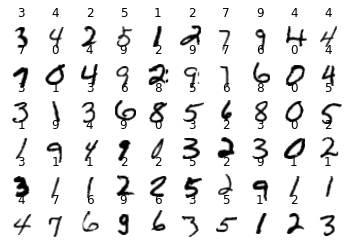

In [19]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.title(str(labels[index-1].item()))
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Create a Model
- will create like 4/5 layers of networks
- not use padding
- channels to be a minimal in number
- create multiple sequential blocks
- 28X28 > 26X26 > 24X24 > 22X22 > MP (11X11) > 9X9 > 7X7 > 1X1

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), padding = 0, bias=False),
            nn.ReLU()
            
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding = 0, bias=False),
            nn.ReLU()
            
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding = 0, bias=False),
            nn.ReLU()
            
        )
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding = 0, bias=False),
            nn.ReLU()
            
        )
        #create a transition 
        
        
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding = 0, bias=False),
            nn.ReLU()
        )
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding = 0, bias=False),
            nn.ReLU()
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(7,7), padding = 0, bias=False),
            nn.ReLU()
        )
        
    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = x.view(-1,10)
        # return x
        return F.log_softmax(x,dim=-1)
            

### Visualize the model

In [21]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           4,608
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8             [-1, 32, 9, 9]           9,216
              ReLU-9             [-1, 32, 9, 9]               0
           Conv2d-10             [-1, 16, 7, 7]           4,608
             ReLU-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 10, 1, 1]           7,840
             ReLU-13             [-1, 10, 1, 1]               0
Total params: 27,496
Trainable para

### Training the Model

In [22]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_ep_loss=0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        loss = F.nll_loss(y_pred, target)
        train_ep_loss+=loss
        train_losses.append(loss)
        
        loss.backward() #backward prop
        optimizer.step()
        
        pred = y_pred.argmax(dim=1, keepdim=True)
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc=f'Loss = {loss.item()} Batch_id = {batch_idx}\
            Accuracy={100*correct/processed:0.2f}')
        
        
        train_acc.append(100*correct/processed)
    print('\nTrain Set Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_ep_loss/len(train_loader.dataset), correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
        
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
            
        
        

In [23]:
len(test_loader.dataset)

10000

In [24]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


EPOCH: 0


Loss = 0.5448538064956665 Batch_id = 468            Accuracy=50.83: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]


Train Set Average loss: 0.0103, Accuracy: 30500/60000 (50.83%)




Test set: Average loss: 0.7986, Accuracy: 6853/10000 (68.53%)

EPOCH: 1


Loss = 0.37259748578071594 Batch_id = 468            Accuracy=81.85: 100%|██████████| 469/469 [01:05<00:00,  7.21it/s]


Train Set Average loss: 0.0037, Accuracy: 49109/60000 (81.85%)




Test set: Average loss: 0.2954, Accuracy: 8862/10000 (88.62%)

EPOCH: 2


Loss = 0.33441153168678284 Batch_id = 468            Accuracy=88.55: 100%|██████████| 469/469 [00:55<00:00,  8.39it/s]


Train Set Average loss: 0.0023, Accuracy: 53127/60000 (88.55%)




Test set: Average loss: 0.2784, Accuracy: 8902/10000 (89.02%)

EPOCH: 3


Loss = 0.4613117277622223 Batch_id = 468            Accuracy=88.91: 100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


Train Set Average loss: 0.0022, Accuracy: 53345/60000 (88.91%)




Test set: Average loss: 0.2731, Accuracy: 8904/10000 (89.04%)

EPOCH: 4


Loss = 0.1665278524160385 Batch_id = 468            Accuracy=89.20: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]


Train Set Average loss: 0.0021, Accuracy: 53519/60000 (89.20%)




Test set: Average loss: 0.2717, Accuracy: 8911/10000 (89.11%)

EPOCH: 5


Loss = 0.24797017872333527 Batch_id = 468            Accuracy=89.33: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]


Train Set Average loss: 0.0020, Accuracy: 53598/60000 (89.33%)




Test set: Average loss: 0.2625, Accuracy: 8923/10000 (89.23%)

EPOCH: 6


Loss = 0.16421061754226685 Batch_id = 468            Accuracy=89.39: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Train Set Average loss: 0.0020, Accuracy: 53634/60000 (89.39%)




Test set: Average loss: 0.2678, Accuracy: 8916/10000 (89.16%)

EPOCH: 7


Loss = 0.29143816232681274 Batch_id = 468            Accuracy=89.50: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]


Train Set Average loss: 0.0020, Accuracy: 53700/60000 (89.50%)




Test set: Average loss: 0.2574, Accuracy: 8947/10000 (89.47%)

EPOCH: 8


Loss = 0.4211238920688629 Batch_id = 468            Accuracy=89.59: 100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Train Set Average loss: 0.0020, Accuracy: 53757/60000 (89.59%)




Test set: Average loss: 0.2623, Accuracy: 8919/10000 (89.19%)

EPOCH: 9


Loss = 0.2401077300310135 Batch_id = 468            Accuracy=89.68: 100%|██████████| 469/469 [00:55<00:00,  8.39it/s]


Train Set Average loss: 0.0019, Accuracy: 53809/60000 (89.68%)




Test set: Average loss: 0.2634, Accuracy: 8928/10000 (89.28%)

EPOCH: 10


Loss = 0.2306678295135498 Batch_id = 468            Accuracy=89.72: 100%|██████████| 469/469 [00:57<00:00,  8.18it/s]


Train Set Average loss: 0.0019, Accuracy: 53829/60000 (89.72%)




Test set: Average loss: 0.2625, Accuracy: 8920/10000 (89.20%)

EPOCH: 11


Loss = 0.16307324171066284 Batch_id = 468            Accuracy=89.70: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]


Train Set Average loss: 0.0019, Accuracy: 53822/60000 (89.70%)




Test set: Average loss: 0.2634, Accuracy: 8929/10000 (89.29%)

EPOCH: 12


Loss = 0.2180330753326416 Batch_id = 468            Accuracy=89.72: 100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Train Set Average loss: 0.0019, Accuracy: 53833/60000 (89.72%)




Test set: Average loss: 0.2628, Accuracy: 8923/10000 (89.23%)

EPOCH: 13


Loss = 0.26939061284065247 Batch_id = 468            Accuracy=89.77: 100%|██████████| 469/469 [01:01<00:00,  7.67it/s]


Train Set Average loss: 0.0019, Accuracy: 53864/60000 (89.77%)




Test set: Average loss: 0.2623, Accuracy: 8935/10000 (89.35%)

EPOCH: 14


Loss = 0.2283296138048172 Batch_id = 468            Accuracy=89.83: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s]


Train Set Average loss: 0.0019, Accuracy: 53897/60000 (89.83%)




Test set: Average loss: 0.2669, Accuracy: 8930/10000 (89.30%)

EPOCH: 15


Loss = 0.19623516499996185 Batch_id = 468            Accuracy=89.88: 100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Train Set Average loss: 0.0019, Accuracy: 53928/60000 (89.88%)




Test set: Average loss: 0.2617, Accuracy: 8936/10000 (89.36%)

EPOCH: 16


Loss = 0.2630264461040497 Batch_id = 468            Accuracy=89.88: 100%|██████████| 469/469 [00:57<00:00,  8.13it/s]


Train Set Average loss: 0.0019, Accuracy: 53930/60000 (89.88%)




Test set: Average loss: 0.2658, Accuracy: 8932/10000 (89.32%)

EPOCH: 17


Loss = 0.3167223036289215 Batch_id = 468            Accuracy=89.89: 100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Train Set Average loss: 0.0019, Accuracy: 53932/60000 (89.89%)




Test set: Average loss: 0.2622, Accuracy: 8923/10000 (89.23%)

EPOCH: 18


Loss = 0.1646680235862732 Batch_id = 468            Accuracy=89.94: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s]


Train Set Average loss: 0.0018, Accuracy: 53961/60000 (89.94%)




Test set: Average loss: 0.2686, Accuracy: 8908/10000 (89.08%)

EPOCH: 19


Loss = 0.12098425626754761 Batch_id = 468            Accuracy=89.91: 100%|██████████| 469/469 [00:55<00:00,  8.39it/s]


Train Set Average loss: 0.0018, Accuracy: 53946/60000 (89.91%)




Test set: Average loss: 0.2675, Accuracy: 8925/10000 (89.25%)

